In [1]:
# Importing libraries 
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
import seaborn as sns
import links as lk
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


### Google Sheets Sign-Up

In [2]:
# Set Up Authentication for google sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
client = gspread.authorize(creds)

# Open Google Sheet by URL
sheet_url = lk.sheet_url
sheet = client.open_by_url(sheet_url).sheet1  # Second sheet for preparing the models only 

# Convert Sheet Data to Pandas DataFrame
data = sheet.get_all_values()
df = pd.DataFrame(data)

### Data Cleaning

In [3]:
# Set First Row as Column Names
df.columns = df.iloc[0]  # Assign first row as headers
df = df[1:]  # Remove the first row from data

# Drop Unnecessary Columns
df = df.drop(df.columns[11:], axis=1)  # Drop all columns from index 9 onward
print("Column names:", df.columns.tolist())  # Check the column names

df.head()

Column names: ['Timestamp', 'Device', 'Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Occupancy']


,Timestamp,Device,Temperature (C),Temperature (F),Humidity,Co2,ADC,Voltage,Pressure,Airspeed,Occupancy
1,2025-03-24 00:28:27,Pico_1,26.2,79.16,62.8,1470.098,N/A,N/A,N/A,N/A,3
2,2025-03-24 00:28:50,Pico_1,26.2,79.16,61.9,832.6554,N/A,N/A,N/A,N/A,3
3,2025-03-24 00:33:46,Pico_1,25.6,78.08,59.6,1549.979,N/A,N/A,N/A,N/A,3
4,2025-03-24 00:34:15,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3
5,2025-03-24 00:34:25,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3


In [4]:
# Dropping Columns not used in this model analysis 
df = df.drop(df.columns[6:], axis=1)
df = df.drop('Device', axis=1)  
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
1,2025-03-24 00:28:27,26.2,79.16,62.8,1470.098
2,2025-03-24 00:28:50,26.2,79.16,61.9,832.6554
3,2025-03-24 00:33:46,25.6,78.08,59.6,1549.979
4,2025-03-24 00:34:15,25.3,77.54,58.4,0
5,2025-03-24 00:34:25,25.3,77.54,58.4,0


In [5]:
# Dropping columns which were used for testing the sensors 
df = df.drop(index=range(1, 11)).reset_index(drop=True)
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
0,2025-03-24 00:51:28,26,78.8,93.1,215.3802
1,2025-03-24 00:51:51,26.1,78.98,92.9,474.9321
2,2025-03-24 00:52:14,26.3,79.34,91.7,244.8746
3,2025-03-24 00:52:37,26.5,79.7,90.9,430.0756
4,2025-03-24 00:53:00,26.7,80.06,90.6,380.2175


In [6]:
# List of variables
vars_to_clean = ['Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2']

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Clean and convert each variable
for v in vars_to_clean:
    df[v] = pd.to_numeric(df[v].replace(['', ' ', 'N/A'], '0'), errors='coerce').fillna(0)


In [7]:
# Converting N/A values to 0 and changing data types
var = ['Temperature (C)','Temperature (F)', 'Humidity', 'Co2']
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Convert Timestamp to datetime
for var in var:
    df[var] = df[var].astype(float)  # Replace N/A with 0 and convert to float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        3966 non-null   datetime64[ns]
 1   Temperature (C)  3966 non-null   float64       
 2   Temperature (F)  3966 non-null   float64       
 3   Humidity         3966 non-null   float64       
 4   Co2              3966 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.1 KB


#### Creating a batch for forecasting

In [8]:
# Creating a column to differentiate between the timings of the data
df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds() # Calculate time difference between rows
df["Batch"] = (df["Time_Diff"] > 120).cumsum() # Create batch number based on time difference
df = df.drop(columns=["Time_Diff"])         # Drop the time difference column
latest_batch = df["Batch"].max()          # Get the latest batch number
data = df[df["Batch"] == latest_batch].copy() # Filter the latest batch data
data.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
2327,2025-03-24 22:20:05,28.6,83.48,84.0,439.931400,6
2328,2025-03-24 22:21:00,28.5,83.30,84.4,485.040700,6
2329,2025-03-24 22:21:24,28.6,83.48,84.5,474.973900,6
2330,2025-03-24 22:21:48,28.6,83.48,84.4,444.983900,6
2331,2025-03-24 22:22:11,28.6,83.48,84.4,7.634521,6


#### Dropping unecessary CO2 columns 

In [9]:
# Identify rows to drop based on the condition in CO2 column
drop_indices = []

for i in range(1, len(data) - 1):  # Start from index 1 to avoid out-of-bounds errors
    if data['Co2'].iloc[i] < 250: 
        drop_indices.append(data.index[i])  # Store index to drop

# Drop the identified rows which
data = data.drop(index=drop_indices).reset_index(drop=True)
data.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
0,2025-03-24 22:20:05,28.6,83.48,84.0,439.9314,6
1,2025-03-24 22:21:00,28.5,83.30,84.4,485.0407,6
2,2025-03-24 22:21:24,28.6,83.48,84.5,474.9739,6
3,2025-03-24 22:21:48,28.6,83.48,84.4,444.9839,6
4,2025-03-24 22:22:35,28.6,83.48,84.4,414.9689,6


### Data Visualization

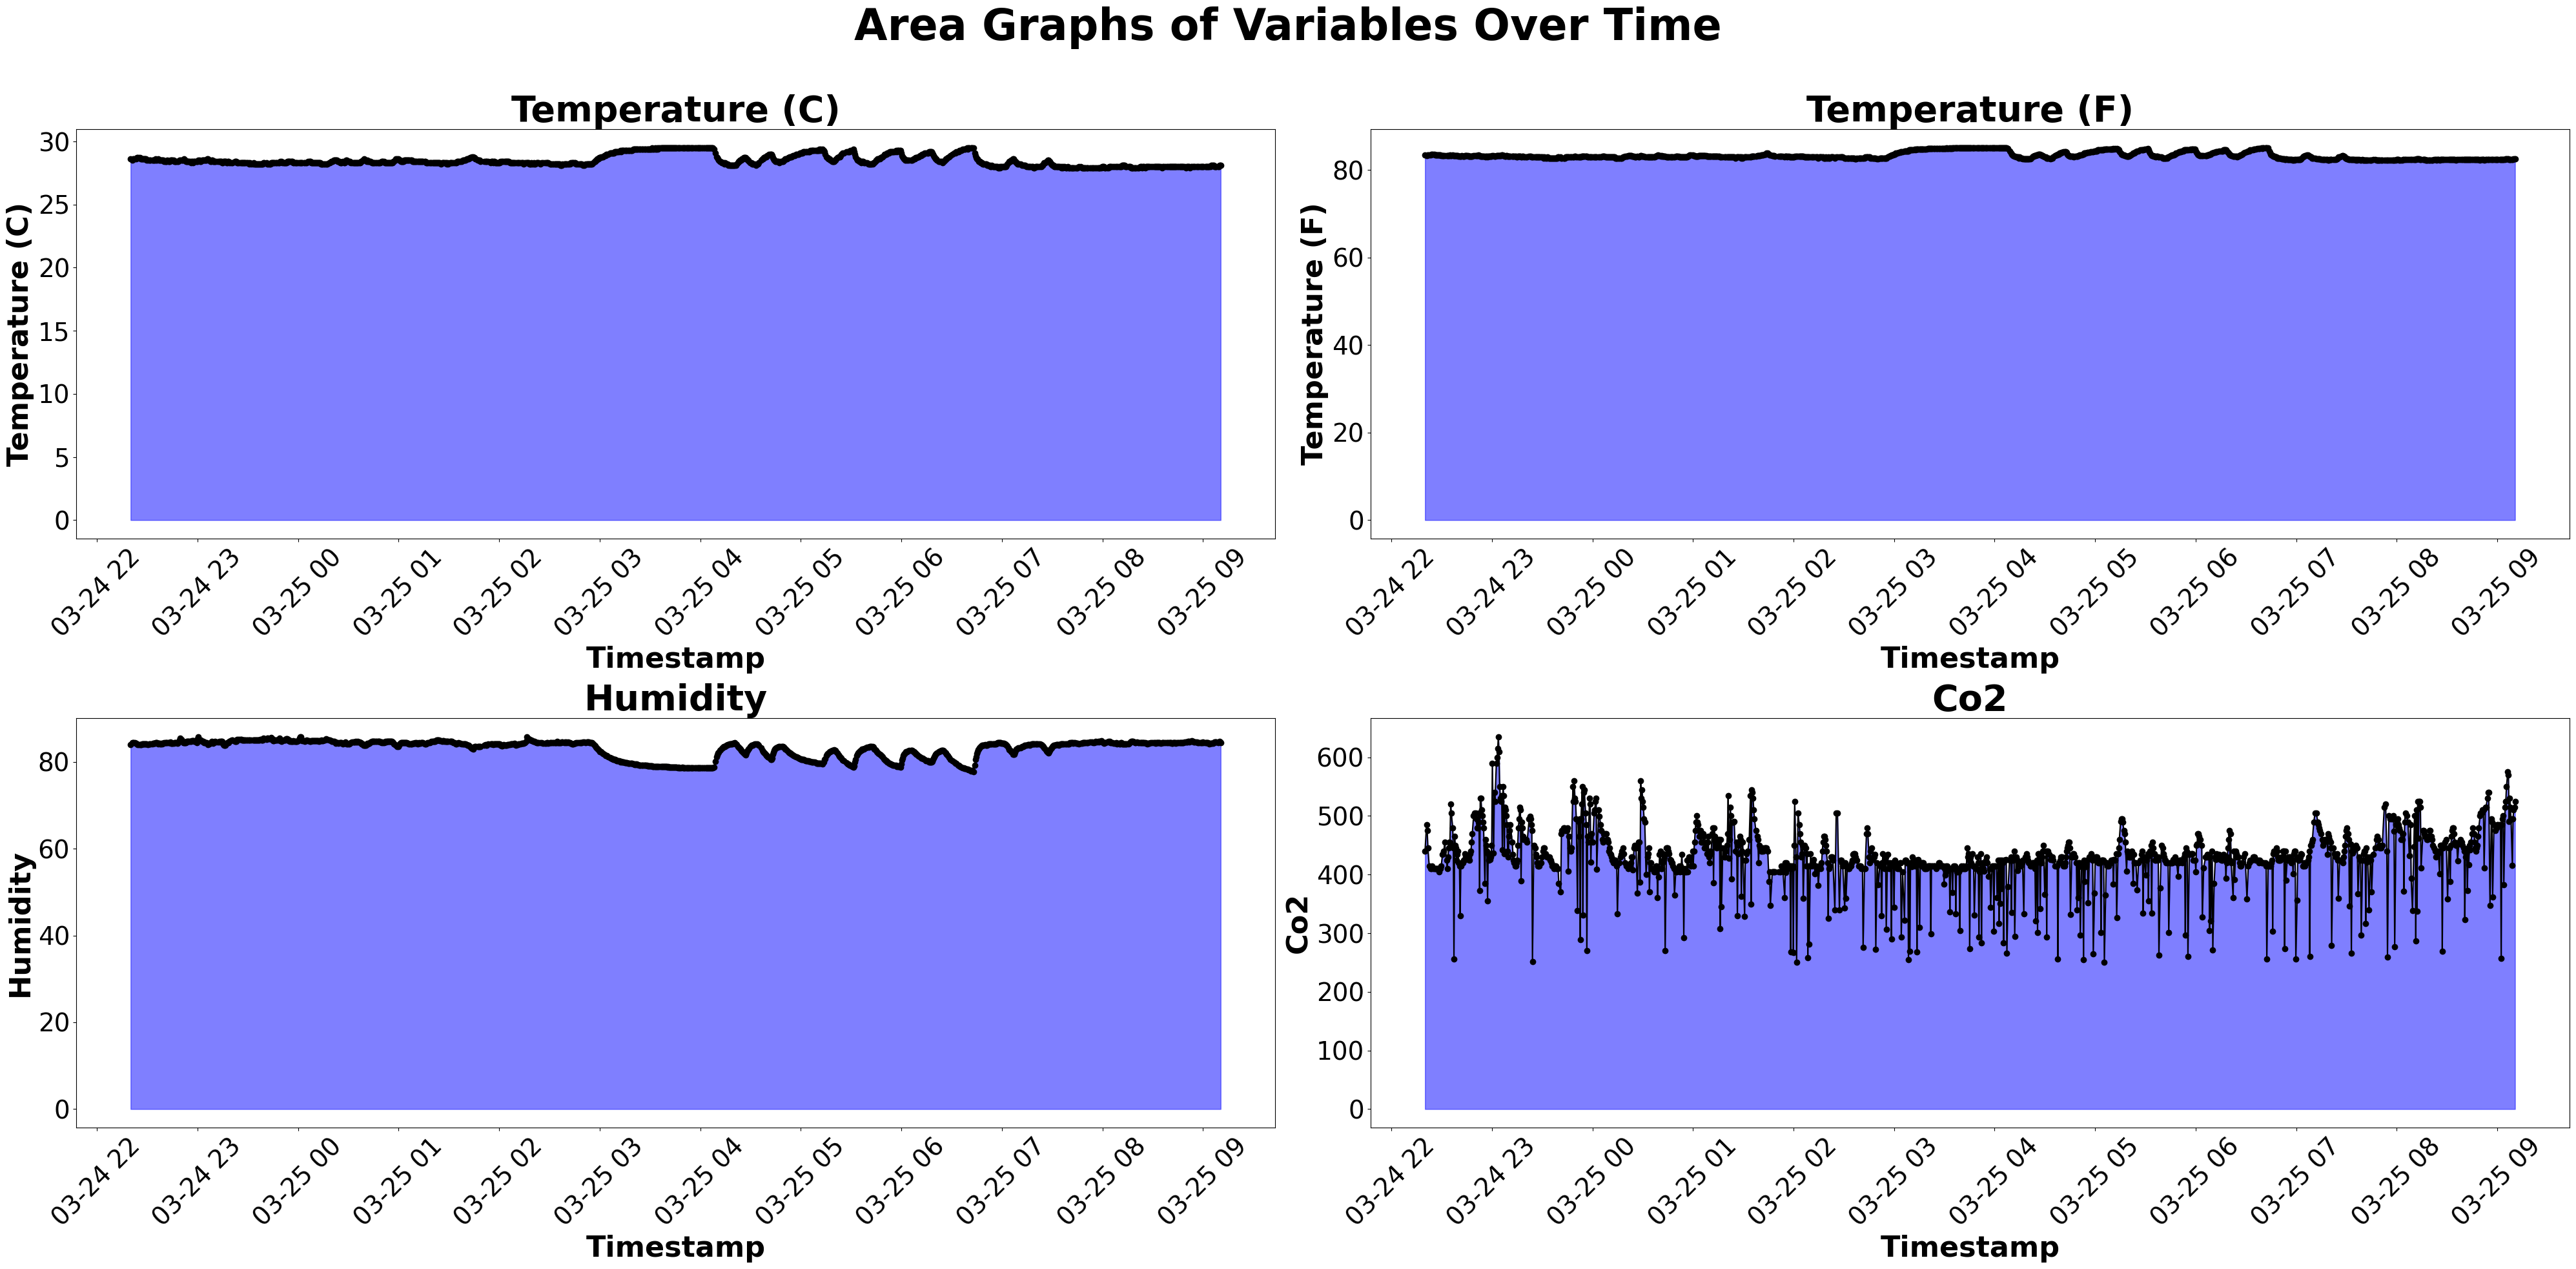

In [10]:
# Create 2x2 subplots with a larger figure size
fig, axes = plt.subplots(2, 2, figsize=(40, 20))
fig.suptitle("Area Graphs of Variables Over Time", fontsize=48, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()
variables = ["Temperature (C)", "Temperature (F)", "Humidity", "Co2"]

# Plot each variable
for i, var in enumerate(variables):
    ax = axes[i]
    ax.fill_between(data["Timestamp"], data[var], alpha=0.5, color="blue")
    ax.plot(data["Timestamp"], data[var], marker="o", linestyle="-", color="black")

    # Styling
    ax.set_title(var, fontsize=40, fontweight='bold')
    ax.set_xlabel("Timestamp", fontsize=32, fontweight='bold')
    ax.set_ylabel(var, fontsize=32, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=28)
    ax.tick_params(axis='y', labelsize=28)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


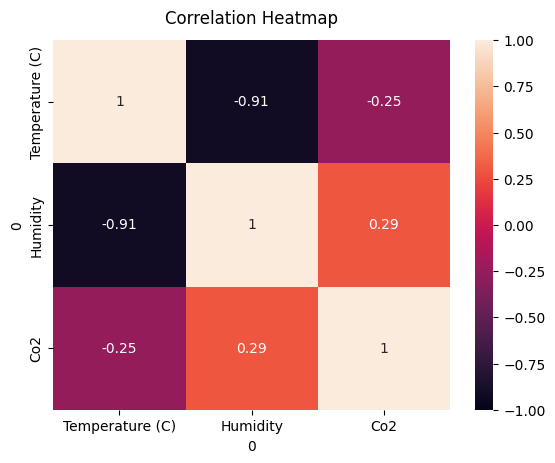

In [30]:
x = ['Temperature (C)', 'Humidity', 'Co2']
heatmap = sns.heatmap(data[x].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Models

#### Thermal Comfort Model - Based on Ashare comfort zone 

In [40]:
def thermal_comfort_score(temp_c, rh_percent):
    if 22 <= temp_c <= 26 and 30 <= rh_percent <= 70:
        return 0
    if ((24 <= temp_c < 26 or 26 < temp_c <= 29) and (20 <= rh_percent <= 80)) or \
       ((24 <= temp_c <= 28) and (60 < rh_percent <= 85)):
        return 1
    return 2

# Apply row-wise using lambda
data['Comfort Score'] = data.apply(lambda row: thermal_comfort_score(row['Temperature (C)'], row['Humidity']), axis=1)
print(data['Comfort Score'].value_counts())
data.head()

Comfort Score
2    1110
1     224
Name: count, dtype: int64


,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch,Comfort Score
1970-01-01 00:00:00.000000000,2025-03-24 22:20:05,28.6,83.48,84.0,439.9314,6,2
1970-01-01 00:00:00.000000001,2025-03-24 22:21:00,28.5,83.30,84.4,485.0407,6,2
1970-01-01 00:00:00.000000002,2025-03-24 22:21:24,28.6,83.48,84.5,474.9739,6,2
1970-01-01 00:00:00.000000003,2025-03-24 22:21:48,28.6,83.48,84.4,444.9839,6,2
1970-01-01 00:00:00.000000004,2025-03-24 22:22:35,28.6,83.48,84.4,414.9689,6,2


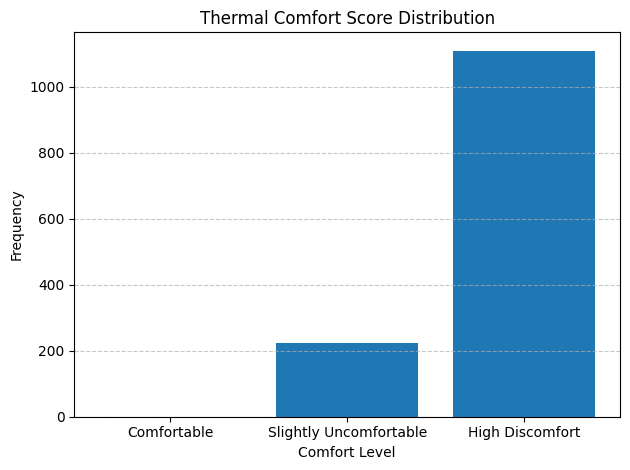

In [45]:
import matplotlib.pyplot as plt

# Count scores and ensure all categories are represented
score_labels = {0: "Comfortable", 1: "Slightly Uncomfortable", 2: "High Discomfort"}
score_counts = data['Comfort Score'].value_counts().sort_index()

# Fill missing score categories with 0
for score in score_labels:
    if score not in score_counts:
        score_counts[score] = 0

# Sort again to match 0, 1, 2 order
score_counts = score_counts.sort_index()

# Plot
plt.bar(score_counts.index, score_counts.values, tick_label=[score_labels[s] for s in score_counts.index])
plt.xlabel("Comfort Level -->")
plt.ylabel("Frequency -->")
plt.title("Thermal Comfort Score Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
